**Подключение библиотек и скриптов**

In [295]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [296]:
# Задание размера шрифта на графиках
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [297]:
TRAIN_DATASET = '/content/drive/MyDrive/Colab Notebooks/train.csv'
TEST_DATASET = '/content/drive/MyDrive/Colab Notebooks/test.csv'

**Загрузка данных**

**Описание датасета**

**Id** - идентификационный номер квартиры

**DistrictId** - идентификационный номер района

**Rooms** - количество комнат

**Square** - площадь

**LifeSquare** - жилая площадь

**KitchenSquare** - площадь кухни

**Floor** - этаж

**HouseFloor** - количество этажей в доме

**HouseYear** - год постройки дома

**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности

**Social_1, Social_2, Social_3** - социальные показатели местности

**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья

**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров

**Price** - цена квартиры

In [298]:
# Загрузка тренировочных данных
train_df = pd.read_csv(TRAIN_DATASET)

In [299]:
# Загрузка тестовых данных
test_df = pd.read_csv(TEST_DATASET)

**Уменьшение объема памяти, который занимает датасет**

In [300]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [301]:
# Оптимизация исходного тренировочного датафрейма
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


**Приведение типов данных**

In [302]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

ID и DistrictId можно перевести его в строковый тип данных:

In [303]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

**Первичный анализ структуры данных**

In [304]:
# Первые 10 строк тренировочного датафрейма
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
5,5804,99,3.0,62.528465,47.103832,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.937500
6,8864,44,1.0,33.938751,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.734375
7,13072,59,2.0,50.391815,32.893257,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.187500
8,9951,1,1.0,46.887894,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.406250
9,8094,6,3.0,79.867477,75.085129,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.031250


In [305]:
# Информация о тренировочных данных
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

*Очевидно, что пропуски есть у признаков "LifeSquare", "Healthcare_1".*

In [306]:
# Информация о тестовых данных
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

За исключением целевого признака "Price", остальные совпадают с тренировочными данными.

 **1. Целевая переменная**

Подсчет среднего, медианы и моды для целевого признака:

In [307]:
price_mean = round(train_df['Price'].mean(), 2)
price_median = train_df['Price'].median()
price_mode = train_df['Price'].mode()[0]

Визуализация распределения целевой переменной:

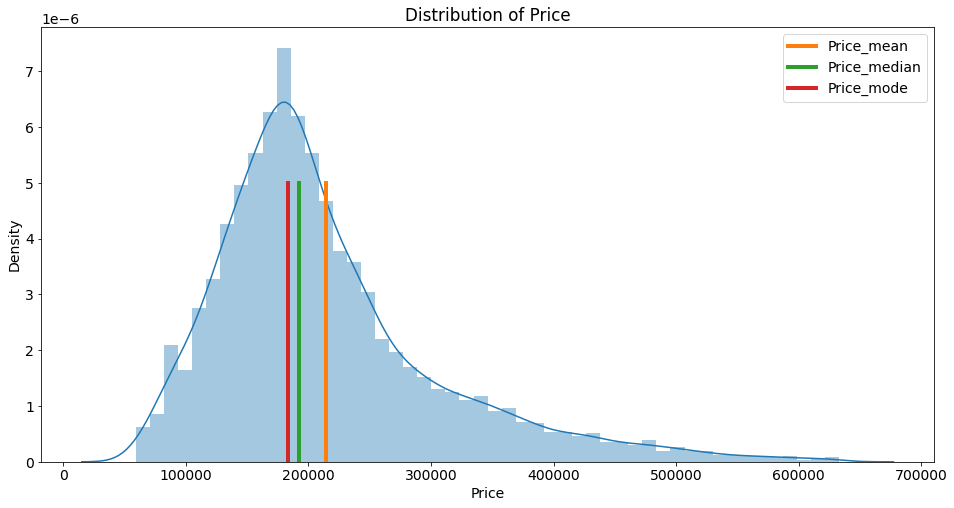

In [308]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([price_mean] * 10, y, label='Price_mean',  linewidth=4)
plt.plot([price_median] * 10, y, label='Price_median',  linewidth=4)
plt.plot([price_mode] * 10, y, label='Price_mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

Каких-либо выбросов или некорретных данных, на первый взгляд, не наблюдается.

 **2. Обзор количественных переменных**

In [309]:
train_df_num_features = train_df.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32'])

In [310]:
train_df_num_features.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


**3. Обзор номинативных переменных**

In [311]:
train_df_cat_features = train_df.select_dtypes(include=['object', 'category'])
train_df_cat_features.head()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,11809,27,B,B,B
1,3013,22,B,B,B
2,8215,1,B,B,B
3,2352,1,B,B,B
4,13866,94,B,B,B


In [312]:
# Самое популярное значение признака Ecology_2
train_df_cat_features['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [313]:
# Самое популярное значение признака Ecology_3
train_df_cat_features['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [314]:
# Самое популярное значение признака Shops_2
train_df_cat_features['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

**4. Обработка выбросов**

In [315]:
train_df_num_features = train_df.select_dtypes(include=['int8', 'int16', 'float32', 'float64'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f42b9b6a4d0>,
      dtype=object)

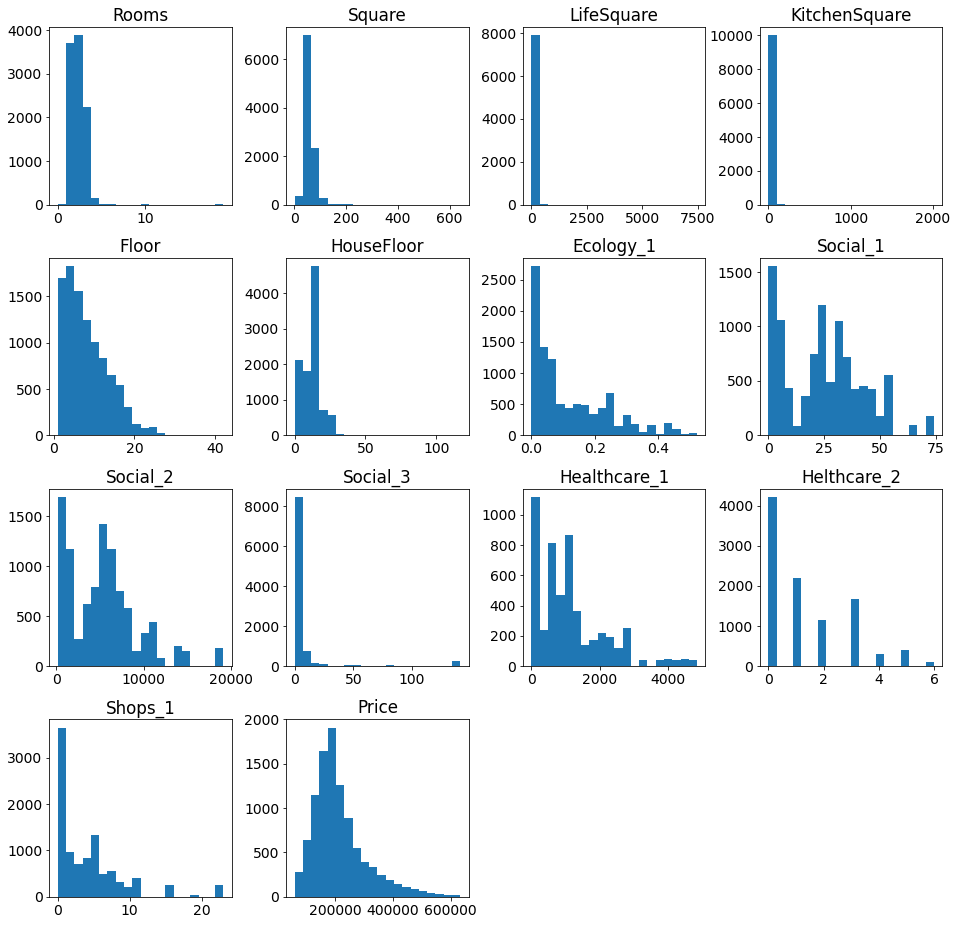

In [316]:
train_df_num_features.hist(figsize=(16, 16), bins=20, grid=False)

Функция *outliners* для обработки выбросов:
если значения признаков не будут попадать в интервал от y% квантиля до z% квантиля, значения будут считаться выбросами и будут заменены на медиану.

In [317]:
def outliners(x, y, z):
  square_min_value = np.quantile(train_df[x], q=y)
  square_max_value = np.quantile(train_df[x], q=z)
  condition = (train_df[x] > square_max_value) | (train_df[x] < square_min_value)
  train_df.loc[condition, x] = train_df[x].median()
  return train_df[x]

**"Rooms", "Square", "KitchenSquare", "Ecology_1", "Social_2", "Social_3", "Healthcare_1", "Healthcare_2", "Shops_1", "HouseYear"**

Если значения признака не будут попадать в интервал от 2,5% квантиля до 97,5% квантиля, значения будут считаться выбросами и будут заменены на медиану.

In [318]:
features_outliners_first = ['Rooms', 'Square', 'KitchenSquare', 'Ecology_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']

In [319]:
for i in features_outliners_first:
  outliners(i, 0.025, 0.975)

**"KitchenSquare"**

Если значения признака будут меньше 3 кв.м, заменим значения на 3.

In [320]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

**"Floor", "HouseFloor"**

Если значения признака будут превышать 97,5% квантиля, значения будут считаться выбросами и будут заменены на медиану.
Допустим также, что величина "0" - это цокольный этаж.

In [321]:
features_outliners_second = ['Floor', 'HouseFloor']

In [322]:
for i in features_outliners_second:
  outliners(i, 0, 0.975)

Если номер этажа больше, чем количество этажей в доме, будем указывать целое число от деления количества этажей в доме на 2.

In [323]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = train_df['HouseFloor'] // 2

**"HouseYear"**

Если значения признака будут превышать текущий год, значения будут считаться выбросами и будут заменены на медиану.

In [324]:
train_df.loc[train_df['HouseYear'] > datetime.now().year, 'HouseYear'] = train_df['HouseYear'].median()

**5. Обработка пропусков**

In [325]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Пропуски встречаются в признаках "LifeSquare", "Healthcare_1".

Создадим новые признаки, чтобы указать, где были заполнены пропуски:

In [326]:
train_df['LifeSquare_nan'] = 0
train_df['Healthcare_1_nan'] = 0

Новые признаки "LifeSquare_nan, Healthcare_1_nan" заполняются значением "1" в строках, где есть "NaN" у признаков "LifeSquare" и "Healthcare_1":

In [327]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1

Заполним пропуски у признака "LifeSquare" значениями "Square - KitchenSquare - train_df['Square']*0.2":

In [328]:
train_df['LifeSquare'].fillna((train_df['Square'] - train_df['KitchenSquare'] - train_df['Square']*0.2), inplace=True)

Пропуски у признака "Healthcare_1" заполним значением медианы признака Healthcare_1":

In [329]:
median = train_df['Healthcare_1'].median()
train_df['Healthcare_1'].fillna(median, inplace=True)

Если 'HouseFloor' или 'Floor' указаны нулевыми, заменим значение на 1.

In [330]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = 1
train_df.loc[train_df['Floor'] == 0, 'Floor'] = 1

Проверим, остались ли еще пропуски:

In [331]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
LifeSquare_nan      0
Healthcare_1_nan    0
dtype: int64

Так как в результате заполнения разностью значений "Square - KitchenSquare - train_df['Square']*0.2" могли возникнуть отрицательные величины, проверим, все ли значения у признака "LifeSquare" положительны.

In [332]:
sum(n < 0 for n in train_df['LifeSquare'])

0

In [333]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Id                10000 non-null  object  
 1   DistrictId        10000 non-null  object  
 2   Rooms             10000 non-null  float32 
 3   Square            10000 non-null  float32 
 4   LifeSquare        10000 non-null  float32 
 5   KitchenSquare     10000 non-null  float32 
 6   Floor             10000 non-null  float64 
 7   HouseFloor        10000 non-null  float32 
 8   HouseYear         10000 non-null  int32   
 9   Ecology_1         10000 non-null  float32 
 10  Ecology_2         10000 non-null  category
 11  Ecology_3         10000 non-null  category
 12  Social_1          10000 non-null  int8    
 13  Social_2          10000 non-null  float64 
 14  Social_3          10000 non-null  float64 
 15  Healthcare_1      10000 non-null  float32 
 16  Helthcare_2       10000

In [334]:
class DataPreprocessing:

  def __init__(self):
    self.medians = None
    self.quantile_min = None
    self.quantile_max = None
    self.districts_healthcare = None

  def fit(self, df):
    # Medians and quantiles
    self.medians = df.median()
    self.quantile_min = df.quantile(0.001)
    self.quantile_max = df.quantile(0.999)
    # Mean Helthcare_1 value in each district
    self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()

  def transform(self, df):
    # Filling outliers in 'Rooms', 'LifeSquare', 'Square', 'KitchenSquare', 'Ecology_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1'
    features_outliers_first = ['Rooms', 'LifeSquare', 'Square', 'KitchenSquare', 'Ecology_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']
    for i in features_outliers_first:
      condition = (df[i] > self.quantile_max[i]) | (df[i] < self.quantile_min[i])
      df.loc[condition, i] = self.medians[i]

    # KitchenSquare = 0 processing
    df.loc[df['KitchenSquare'] < df['Square']*0.3, 'KitchenSquare'] = df['Square']*0.3

    # Filling outliers in'Floor', 'HouseFloor'
    features_outliers_second = ['Floor', 'HouseFloor']
    for i in features_outliners_second:
      condition_s = df[i] > self.quantile_max[i]
      df.loc[condition_s, i] = self.medians[i]

    # HouseFloor = 0 and Floor = 0 processing
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = 1
    df.loc[df['Floor'] == 0, 'Floor'] = 1

    # Floor > HouseFloor mistakes processing
    df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df['HouseFloor'] // 2

    # HouseYear > current year mistakes processing
    df.loc[df['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year

    # Fillna in LifeSquare and Healthcare_1
    df['LifeSquare_nan'] = 0
    df['Healthcare_1_nan'] = 0
    df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
    df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
    df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
    
    # LifeSquare = 0 processing
    df.loc[df['LifeSquare'] == 0, 'LifeSquare'] = df['Square'] - df['KitchenSquare'] - df['Square']*0.2

    # Fillna in dataset
    df.fillna(self.medians, inplace=True)

    return df


In [335]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan
0,11809,27,3.0,52.513309,32.010647,10.0,4.0,10.0,2014,0.075424,B,B,11,3097.0,0.0,900.0,0.0,0.0,B,305018.875000,1,1
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,B,B,30,6207.0,1.0,1183.0,1.0,0.0,B,177734.546875,0,0
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,B,B,33,5261.0,0.0,240.0,3.0,1.0,B,282078.718750,0,0
3,2352,1,1.0,40.409908,29.327927,3.0,10.0,22.0,1977,0.007122,B,B,1,264.0,0.0,900.0,0.0,1.0,B,168106.000000,1,1
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,B,B,33,8667.0,2.0,900.0,0.0,6.0,B,343995.093750,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3.0,12.0,1981,0.300323,B,B,52,10311.0,6.0,900.0,1.0,9.0,B,119367.453125,0,1
9996,16265,27,2.0,64.307686,37.038422,9.0,1.0,1.0,1977,0.072158,B,B,2,629.0,1.0,900.0,0.0,0.0,A,199715.156250,0,1
9997,2795,178,1.0,52.513309,16.555363,5.0,3.0,5.0,1958,0.075424,B,B,20,4386.0,14.0,900.0,1.0,5.0,B,165953.906250,0,1
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,B,B,47,8004.0,3.0,125.0,3.0,5.0,B,171842.406250,0,0


**6. Построение новых признаков**

**Количественные переменные**

Преобразование всех номинативных признаков:

In [336]:
dummies_feature_list = ['Ecology_2', 'Ecology_3', 'Shops_2']
binary_to_numbers = {'A': 0, 'B': 1}
for i in dummies_feature_list:
  train_df[i] = train_df[i].map(binary_to_numbers)

Введем новый признак 
Social_P = |Social_1-Social_2-Social_3| / (Social_1+Social_2+Social_3)

In [337]:
train_df['Social_P'] = abs((train_df['Social_1']-train_df['Social_2']-train_df['Social_3'])/(train_df['Social_1']+train_df['Social_2']+train_df['Social_3']))

Введем новый признак: популярность района.
Он будет равен количеству предложений по всему району.

In [338]:
district_popularity= train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'District_Popularity'})
train_df = train_df.merge(district_popularity, on='DistrictId', how='left')

Экологичность кв метра:

In [339]:
train_df['Ecology_floor_square'] = train_df['Ecology_1'] * train_df['Floor'] / train_df['Square']

По признаку HouseFloor создадим новый с категориями

In [340]:
def house_floor_to_category(df):

  bins = [0, 1, 5, 9, 12, df['HouseFloor'].max()]
  df['HouseFloor_Category'] = pd.cut(df['HouseFloor'], bins=bins, labels=False)
  df['HouseFloor_Category'].fillna(-1, inplace=True)

  return df

train_df = house_floor_to_category(train_df)

In [341]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan,Social_P,District_Popularity,Ecology_floor_square,HouseFloor_Category
0,11809,27,3.0,52.513309,32.010647,10.0,4.0,10.0,2014,0.075424,1,1,11,3097.0,0.0,900.0,0.0,0.0,1,305018.875000,1,1,0.992921,851,0.005745,3
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,1,1,30,6207.0,1.0,1183.0,1.0,0.0,1,177734.546875,0,0,0.990382,78,0.020831,2
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,1,1,33,5261.0,0.0,240.0,3.0,1.0,1,282078.718750,0,0,0.987533,652,0.000654,4
3,2352,1,1.0,40.409908,29.327927,3.0,10.0,22.0,1977,0.007122,1,1,1,264.0,0.0,900.0,0.0,1.0,1,168106.000000,1,1,0.992453,652,0.001763,4
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,1,1,33,8667.0,2.0,900.0,0.0,6.0,1,343995.093750,0,1,0.992416,89,0.070386,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3.0,12.0,1981,0.300323,1,1,52,10311.0,6.0,900.0,1.0,9.0,1,119367.453125,0,1,0.989970,118,0.018353,3
9996,16265,27,2.0,64.307686,37.038422,9.0,1.0,1.0,1977,0.072158,1,1,2,629.0,1.0,900.0,0.0,0.0,0,199715.156250,0,1,0.993671,851,0.001122,0
9997,2795,178,1.0,52.513309,16.555363,5.0,3.0,5.0,1958,0.075424,1,1,20,4386.0,14.0,900.0,1.0,5.0,1,165953.906250,0,1,0.990950,7,0.004309,1
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,1,1,47,8004.0,3.0,125.0,3.0,5.0,1,171842.406250,0,0,0.988329,165,0.018047,2


Деление по категорям возрастов домов.

In [342]:
def year_to_category(df):

  bins = [0, 1920, 1950, 1970, 2000, 2010, df['HouseYear'].max()]
  df['Year_Category'] = pd.cut(df['HouseYear'], bins=bins, labels=False)
  df['Year_Category'].fillna(-1, inplace=True)

  return df

In [343]:
train_df = year_to_category(train_df)

In [344]:
class FeatureGenerator():

  def __init__(self):
    self.house_year_max = None
    self.house_floor_max = None
    self.district_popularity = None
    self.district_popularity_median = None
    self.binary_to_numbers = None
    self.med_price_by_district = None
    self.district_popularity = None
    self.districts_Ecology_2 = None

  def fit(self, df, y=None):
    df = df.copy()
    df['Price'] = y.values
    
    self.binary_to_numbers = {'A': 0, 'B': 1}
    self.district_popularity= df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'District_Popularity'})
    self.house_floor_max = df['HouseFloor'].max()

  def year_to_category(df):
    #Year to category
    bins = [0, 1920, 1950, 1970, 2000, 2010, self.house_year_max ['HouseYear']]
    df['Year_Category'] = pd.cut(df['HouseYear'], bins=bins, labels=False)
    df['Year_Category'].fillna(-1, inplace=True)
    return df

  def house_floor_to_category(df):
    #House floor to category
    bins = [0, 1, 5, 9, 12, self.house_floor_max]
    df['HouseFloor_Category'] = pd.cut(df['HouseFloor'], bins=bins, labels=False)
    df['HouseFloor_Category'].fillna(-1, inplace=True)
    return df

  def transform(self, df): 
    # Ecology_2, Ecology_3, Shops_2 to categories
    df['Ecology_2'] = df['Ecology_2'].map(self.binary_to_numbers)
    df['Ecology_3'] = df['Ecology_3'].map(self.binary_to_numbers)
    df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)

    # New feature Social_P
    df['Social_P'] = abs((df['Social_1']-df['Social_2']-df['Social_3'])/(df['Social_1']+df['Social_2']+df['Social_3']))

    # New feature District_Popularity
    df = df.merge(self.district_popularity, on='DistrictId', how='left')
    df['District_Popularity'].fillna(-1, inplace=True)

    # New feature Ecology_floor_square
    df['Ecology_floor_square'] = df['Ecology_1'] * df['Floor'] / df['Square']
    df = year_to_category(df)

    # New feature HouseFloor_Category
    df = house_floor_to_category(df)
    
    return df

**7. Разбиение на train и test**

In [345]:
train_df.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'Social_P',
 'District_Popularity',
 'Ecology_floor_square',
 'HouseFloor_Category',
 'Year_Category']

In [346]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseYear',
                 'HouseFloor','Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 
                 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']

In [347]:
new_feature_names = ['Social_P', 'District_Popularity', 'Ecology_floor_square', 'HouseFloor_Category', 'Year_Category']

In [348]:
target_name = 'Price'

In [349]:
train_df = pd.read_csv(TRAIN_DATASET)
test_df = pd.read_csv(TEST_DATASET)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [350]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [351]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 21), (3300, 21), (5000, 21))

In [352]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [353]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [354]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 21), (3300, 21), (5000, 21))

**8. Построение модели**

Обучение:

In [355]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.025, loss='huber', max_depth=6,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2250,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Оценка модели:

In [356]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
print(r2(y_train, y_train_preds))
print(r2(y_valid, y_test_preds))

0.8580823393630531
0.7655704178752332


Важность признаков:

In [357]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,KitchenSquare,0.198958
1,Square,0.164425
17,District_Popularity,0.126931
0,Rooms,0.083371
12,Social_3,0.060595
2,LifeSquare,0.059501
10,Social_1,0.050791
11,Social_2,0.045284
16,Social_P,0.032814
5,HouseYear,0.026425


**9. Прогнозирование на тестовом датасете**

In [358]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Rooms                 5000 non-null   float64
 1   Square                5000 non-null   float64
 2   LifeSquare            5000 non-null   float64
 3   KitchenSquare         5000 non-null   float64
 4   Floor                 5000 non-null   float64
 5   HouseYear             5000 non-null   int64  
 6   HouseFloor            5000 non-null   float64
 7   Ecology_1             5000 non-null   float64
 8   Ecology_2             5000 non-null   int64  
 9   Ecology_3             5000 non-null   int64  
 10  Social_1              5000 non-null   int64  
 11  Social_2              5000 non-null   float64
 12  Social_3              5000 non-null   float64
 13  Healthcare_1          5000 non-null   float64
 14  Helthcare_2           5000 non-null   float64
 15  Shops_1              

In [359]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [360]:
predictions = gb_model.predict(test_df)
predictions

array([172098.43394157, 122896.11256388, 135486.41709772, ...,
       154583.00671554, 196600.26873694, 253496.71558667])

In [361]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,172098.433942
1,5925,122896.112564
2,960,135486.417098
3,3848,105402.055993
4,746,214950.615048


In [362]:
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/rf_submit.csv', index=False)